In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import sys; sys.path.append('../')
from misc import h5file

import numpy as np
import jax.numpy as jnp
from numpy.random import default_rng
import scipy.io as sio
from scipy.optimize import curve_fit
from jaxfit import CurveFit
from levenberg_marquardt import lm as lm_curve_fit
from statsmodels.api import OLS as SMOLS
import sympy
import pandas as pd

import torch, sympytorch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from siren_pytorch import SirenNet

import pysindy as ps

from sympy import symbols, sympify, simplify, lambdify
from mathparser import math_eval
from varname import nameof

import sys; sys.path.append('../optimizers/')
from Adan import Adan

import sys; sys.path.append('../../parametric-discovery/')
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff, savgol_denoise
from functools import partial
from best_subset import composite_function, ps_features
import derivative

def percent_coeff_error(pred):
    ground = np.array([0.1, -1])
    errs = 100*np.abs(np.array(pred)-ground)/np.abs(ground)
    return errs.mean(), errs.std()

MAIN_SEED = 1234

Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
class KalmanDiff(ps.BaseDifferentiation):
    def __init__(self, alpha, poly_deg=None, rpca_lambda=None, d=1, axis=1, is_uniform=True, periodic=False):
        super(KalmanDiff, self).__init__()
        # Kalman diff
        self.alpha = alpha
        self.diff_func = derivative.Kalman(alpha=self.alpha)
        self.d = d
        self.diff = partial(pysindydiff, **{"diff_method":self.diff_func, "order":self.d})
        # Savgol denoising
        self.poly_deg = poly_deg
        if poly_deg is not None:
            if poly_deg%2 == 0: window_length = self.poly_deg + 1
            else: window_length = self.poly_deg + 2
            self.denoise = partial(savgol_denoise, **{"window_length":window_length, "poly_deg":self.poly_deg})
        else:
            self.denoise = lambda _: _
        # Robust PCA
        self.rpca_lambda = rpca_lambda
        # Other info...
        self.axis = axis
        self.is_uniform = is_uniform
        self.periodic = periodic
        # data transformation
        # rs = np.ones(2).astype(np.int32); rs[self.axis] = -1; rs = tuple(rs)
        self.transform = np.vectorize(composite_function(self.diff, self.denoise, left2right=True), signature="(m),(m)->(m)")
    # _differentiate
    def _differentiate(self, x, t):
        in_shape = x.shape
        if len(in_shape) == 2: x = np.expand_dims(x, -1) # x should now be 3-dimensional
        if isinstance(t, float) and self.is_uniform: 
            t = np.linspace(0, stop=t*(x.shape[self.axis]-1), num=x.shape[self.axis])
        out = []
        # wrt to x var
        if self.axis == 0:
            for i in range(x.shape[-1]):
                # use lambda and partial from functools to help shorten the code
                # diff = np.hstack([self.denoise(self.diff(x[:, j:j+1, i], t)).reshape(-1, 1) 
                #                   for j in range(x.shape[1])])
                # diff = np.hstack([self.transform(x[:, j:j+1, i], t) for j in range(x.shape[1])])
                # diff = np.vectorize(self.transform, signature="(m),(m)->(m)")(x[:,:,i].T, t).T
                diff = self.transform(x[:,:,i].T, t).T
                if self.rpca_lambda is not None:
                    diff = self._get_low_rank(diff)
                out.append(np.expand_dims(diff, axis=-1))
        # wrt to time var
        elif self.axis == 1:
            for i in range(x.shape[-1]):
                # use lambda and partial from functools to help shorten the code
                # diff = np.vstack([self.denoise(self.diff(x[j:j+1, :, i], t)).reshape(1, -1) 
                #                   for j in range(x.shape[0])])
                # diff = np.vstack([self.transform(x[j:j+1, :, i], t) for j in range(x.shape[0])])
                # diff = np.vectorize(self.transform, signature="(m),(m)->(m)")(x[:,:,i], t)
                diff = self.transform(x[:,:,i], t)
                if self.rpca_lambda is not None:
                    diff = self._get_low_rank(diff)
                out.append(np.expand_dims(diff, axis=-1))
        return np.concatenate(out, axis=-1).reshape(in_shape)
    # _get_low_rank
    def _get_low_rank(self, x):
        rpca = RobustPCA(lamb=self.rpca_lambda, tol=10, use_fbpca=True, max_iter=int(1e6))
        rpca.fit(x)
        return rpca.get_low_rank()

In [3]:
noise_lv = 30
denoising_mode = 'ksvd'
smoother_name = 'none'
n_components = 32
transform_n_nonzero = '_none'
undenoised = True

fp1 = f"../PMS_data/{denoising_mode}/{smoother_name}/transform_n_nonzero_coefs{transform_n_nonzero}/burgers_pms_noise30_dictlearn{n_components}.h5"
fp2 = f"../PMS_data/{denoising_mode}/{smoother_name}/transform_n_nonzero_coefs{transform_n_nonzero}/burgers_pms_feature_names_noise30_dictlearn{n_components}.yaml"

fp1, fp2

('../PMS_data/ksvd/none/transform_n_nonzero_coefs_none/burgers_pms_noise30_dictlearn32.h5',
 '../PMS_data/ksvd/none/transform_n_nonzero_coefs_none/burgers_pms_feature_names_noise30_dictlearn32.yaml')

In [4]:
# RDAE, noRDAE
X_pre, avg_weak_coeff, best_subsets, un, y_pre = \
h5file(file_path=fp1, mode='r', return_dict=False)

['X_pre', 'avg_weak_coeff', 'best_subsets', 'un', 'y_pre']


In [5]:
import yaml
# RDAE, noRDAE
with open(fp2, 'r') as f:
    config = yaml.load(f, yaml.Loader)
f.close()
encoded_feature_names = config["encoded_feature_names"]
encoded_pde_names = config["encoded_pde_names"]
encoded_pde_names

['u*u_1',
 'u_11+u*u_1',
 'u_11+u*u_1+u*u_11',
 'u*u+u_11+u*u_1+u*u_11',
 'u*u+u_11+u*u_1+u*u_11+u*u*u_11',
 'u+u_11+u*u_1+u*u*u_1+u*u_11+u*u*u_11',
 'u+u*u+u_11+u*u_1+u*u*u_1+u*u_11+u*u*u_11',
 'u+u*u+u_1+u_11+u*u_1+u*u*u_1+u*u_11+u*u*u_11']

In [6]:
[np.linalg.lstsq(X_pre[:, np.where(best_subsets[i]>0)[0]], 
                 y_pre, rcond=None)[0].flatten() for i in range(len(best_subsets))]

[array([-0.94982265]),
 array([ 0.10333732, -1.01090519]),
 array([ 0.10181422, -1.01283594,  0.00382179]),
 array([ 0.01903247,  0.09470794, -1.03244443,  0.03655137]),
 array([ 0.02897648,  0.08589665, -1.04344999,  0.11834471, -0.08579327]),
 array([ 0.01118762,  0.08081364, -1.10689672,  0.1380752 ,  0.14349872,
        -0.12611543]),
 array([ 0.0149017 , -0.01100499,  0.08026832, -1.11188674,  0.15397224,
         0.14450445, -0.13309605]),
 array([ 0.02238456, -0.0337031 , -0.03180929,  0.07727429, -0.93468639,
        -0.03071235,  0.14030971, -0.13712723])]

In [7]:
from itertools import combinations

sus = [2,3]
for target_com in sus:
    all_subsets = list(combinations(range(len(config["encoded_feature_names"])), target_com))
    scores = []
    for s in all_subsets:
        inp = X_pre[:, s]
        w = np.linalg.lstsq(inp, y_pre, rcond=None)[0]
        scores.append(((y_pre-inp@w)**2).mean())

    print(all_subsets[np.argmin(scores)])
    print('+'.join([config["encoded_feature_names"][i] for i in all_subsets[np.argmin(scores)]]))
    print(np.linalg.lstsq(X_pre[:, all_subsets[np.argmin(scores)]], y_pre, rcond=None)[0].flatten())
    print()

(3, 4)
u_11+u*u_1
[ 0.10333732 -1.01090519]

(2, 3, 4)
u_1+u_11+u*u_1
[-0.01370488  0.10196836 -0.97529619]



In [8]:
poly_complexities = [name.count('*')+name.count('+')+1 for name in encoded_pde_names]

In [9]:
data = sio.loadmat('../Datasets/burgers.mat')

u_clean = data['usol'].real
x = data['x'][0].real
t = data['t'][:,0].real
dt = t[1]-t[0]; dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

if undenoised:
    np.random.seed(0)
    un = u_clean + 0.01*np.abs(noise_lv)*(u_clean.std())*np.random.randn(u_clean.shape[0], 
                                                                         u_clean.shape[1])
    print("In the Undenoised mode...")
else:
    print("In the Denoised mode...")

In the Undenoised mode...


In [10]:
def log_like_value(prediction, ground):                                                                                                               
    nobs = float(ground.shape[0])
    nobs2 = nobs / 2.0
    ssr = np.sum(np.abs(ground - prediction)**2)
    llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    return llf

def BIC_AIC(prediction, ground, nparams, reg_func = lambda x: x):
    nparams = reg_func(nparams)
    llf = log_like_value(prediction, ground)
    return -2*llf + np.log(ground.shape[0])*nparams, -2*llf + 2*nparams

In [11]:
if smoother_name != 'none': hof = pd.read_csv(f"./hof_{smoother_name}.csv")
else: hof = pd.read_csv(f"./hof.csv")
equation = hof.iloc[np.argmax(hof["score"])]
# how to extract float numbers from a sympy object?
print(equation.equation)
func = lambdify(args=sympy.symbols('x0'), expr=equation.equation)
pysr_params = np.array(sorted([float(atom) for atom in sympify(equation.equation).atoms() if atom.is_number]))
# initial_indices = np.where(X_train[:, 1:2]==0.0)[0]

exp(-1.0023574 * square(2.0152135 + x0))


In [12]:
def initial_function(x, a, b): return np.exp(a*np.square(x+b))
def jax_initial_function(x, a, b): return jnp.exp(a*jnp.square(x+b))

recovered_params1 = np.array(CurveFit().curve_fit(jax_initial_function, x.flatten(), un[:, 0], 
                                                  p0=np.round(pysr_params))[0]) # p0=np.round(pysr_params), p0=None

recovered_params2 = np.array(curve_fit(initial_function, x.flatten(), un[:, 0], 
                                       p0=None, method='lm')[0])

recovered_params3 = lm_curve_fit(np.round(pysr_params).reshape(-1, 1), 
                                 x.flatten(), un[:, 0], 
                                 lambda t,p: np.exp(p[0,0]*np.square(t+p[1,0])))[0].flatten()

recovered_params = recovered_params3 # pysr_params, recovered_params1, recovered_params2, recovered_params3
# recovered_params = np.round(recovered_params, decimals=6)
print(recovered_params)

initial_function = partial(initial_function, a=recovered_params[0], b=recovered_params[1])
# initial_function = partial(initial_function, a=-1.0, b=2.0) # GROUND
# initial_function = func

2023-04-25 17:28:07,129 [INFO] Remote TPU is not linked into jax; skipping remote TPU.
2023-04-25 17:28:07,131 [INFO] Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
2023-04-25 17:28:07,131 [INFO] Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-04-25 17:28:07,132 [INFO] Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-04-25 17:28:07,133 [INFO] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2023-04-25 17:28:07,134 [INFO] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


Using uniform weights for error analysis
**** Convergence in r.h.s. ("JtWdy")  ****
**** Convergence in Parameters ****

LM fitting results:
----------------------------- 
parameter      = p1
fitted value   = -0.9891
standard error = -2.25 %
----------------------------- 
parameter      = p2
fitted value   = 2.0189
standard error = 1.10 %
[-0.98912898  2.01893063]


In [13]:
sim_vals_com2 = sio.loadmat(f"../DeepHPMs/Matlab/burgers_{smoother_name}_est_com2.mat")["usol"]
sim_vals_com3 = sio.loadmat(f"../DeepHPMs/Matlab/burgers_{smoother_name}_est_com3.mat")["usol"]
print(BIC_AIC(sim_vals_com2.reshape(-1, 1), un.reshape(-1, 1), 2))
print(BIC_AIC(sim_vals_com3.reshape(-1, 1), un.reshape(-1, 1), 3))

(-77574.84369689702, -77591.16429281967)
(-77550.06179049311, -77574.54268437707)


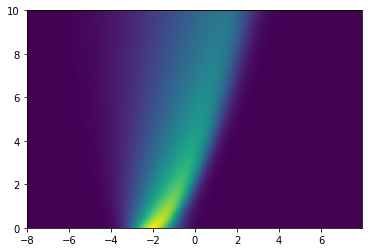

In [14]:
plt.pcolormesh(x, t, sim_vals_com2.T, shading='gouraud')
plt.show()

In [15]:
print('close to un?')
print(((un-sim_vals_com2)**2).mean(), ((un-sim_vals_com3)**2).mean())
print('close to u_clean?')
print(((u_clean-sim_vals_com2)**2).mean(), ((u_clean-sim_vals_com3)**2).mean())

close to un?
0.0029119635508465585 0.0029136107364884324
close to u_clean?
4.638043198279324e-06 9.388479415420815e-06
